In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

In [3]:
def positive_negative_to_binary(v):
    return (v + 1)/2

def binary_to_positive_negative(v):
    return 2*v - 1

# For a synthetic DAG, a variable return -1 if sum of parents is negative and 1 if poisitive
# Noise probability gives the probability of a bit-flip error - .5 gives unbiased coin
def binary_var_from_parents(list_of_parents, noise_probability = .05):
    list_of_parents = np.array(list_of_parents)
    n_datapoints = list_of_parents.shape[1]
    number_of_parents = list_of_parents.shape[0]
    sum_of_parents = np.zeros(n_datapoints)
    for parent in list_of_parents:
        sum_of_parents += parent
    result = sum_of_parents > 0
    # Add some noise
    flip_bit = np.random.binomial(1, noise_probability, n_datapoints)
    result = np.logical_xor(result, flip_bit).astype(int)
    return binary_to_positive_negative(result)

def normal_var_from_parents(list_of_parents, normalizer=1, noise_std = .2):
    vars_of_parents = [np.std(parent)**2 for parent in list_of_parents]
    list_of_parents = np.array(list_of_parents)
    n_datapoints = list_of_parents.shape[1]
    number_of_parents = list_of_parents.shape[0]
    sum_of_parents = np.zeros(n_datapoints)
    for parent in list_of_parents:
        sum_of_parents += parent
    avg_of_parents = sum_of_parents/len(list_of_parents)
    var_of_avg = sum(vars_of_parents)/len(list_of_parents)
    std_of_avg = np.sqrt(var_of_avg)
    avg_of_parents_normalized = (avg_of_parents / std_of_avg)/normalizer
    
    # Add some noise
    noise = np.random.randn(n_datapoints) * noise_std
    result = (avg_of_parents + noise)/(np.sqrt(2))
    return result

In [4]:
def generate_data(n_datapoints, mean_MG = 0, mean_MB = 0, std_MG = 1, std_MB = 1, theta_deg = 0):
    MG = std_MG * np.random.randn(n_datapoints) + mean_MG
    MB = std_MB * np.random.randn(n_datapoints) + mean_MB
    
    UG = normal_var_from_parents([MG])
    Y = binary_var_from_parents([UG])
    UB = normal_var_from_parents([MB, Y])
    
    VG = normal_var_from_parents([UG])
    VA_G = normal_var_from_parents([UG])
    VA_B = normal_var_from_parents([UB])
    VB = normal_var_from_parents([UB])
    
    # Rotating VA_G and VA_B
    theta = np.radians(theta_deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    VA = np.matmul(R, np.array([VA_G, VA_B]))
    
    X = np.transpose(np.array([VG, VA_G, VA_B, VA[0], VA[1], VB]))
    Y = positive_negative_to_binary(Y)
    return X, Y

def post_select_data(X, Y, Y_val):
    where = np.where(Y==Y_val)[0]
    return X[where,:]

class F_isolate:
    def __init__(self, X, y):
        self.get_enhancement_classifiers(X, y)
        enhanced_X = self.enhance(X)
        self.classifier = LogisticRegression(random_state=0).fit(enhanced_X, y)
        
    def score(self, X, y):
        enhanced_X = self.enhance(X)
        return self.classifier.score(enhanced_X, y)
        
    def get_enhancement_classifiers(self, X, y):
        X_PS0 = post_select_data(X, y, 0)
        X_PS1 = post_select_data(X, y, 1)
        self.isolate_VG_0 = LinearRegression().fit(X_PS0[:,[3,4]], X_PS0[:,0])
        self.isolate_VG_1 = LinearRegression().fit(X_PS1[:,[3,4]], X_PS1[:,0])
        
        # Check conditions for improvement
        score0 = self.isolate_VG_0.score(X_PS0[:,[3,4]], X_PS0[:,0])
        score1 = self.isolate_VG_1.score(X_PS1[:,[3,4]], X_PS1[:,0])
        preds0 = self.isolate_VG_0.predict(X[:,[3,4]])
        preds1 = self.isolate_VG_1.predict(X[:,[3,4]])
        regression_using_output_no_conditioning = LinearRegression().fit(np.c_[preds0, preds1], X[:,0])
        no_cond_score = regression_using_output_no_conditioning.score(np.c_[preds0, preds1], X[:,0])
        print("Average Accuracy Conditioning: {}".format(((len(X_PS0) * score0)+ (len(X_PS1) * score1))/len(y)))
        print("Accuracy No Conditioning: {}".format(no_cond_score))
    
    def enhance(self, X):
        VG = X[:,[0]]
        VA = X[:,[3,4]]
        ISO_VG_0 = self.isolate_VG_0.predict(VA)
        ISO_VG_1 = self.isolate_VG_1.predict(VA)
    
        enhanced = np.c_[ VG, ISO_VG_0, ISO_VG_1]
        return enhanced
    
class F_remove:
    def __init__(self, X, y):
        self.get_enhancement_classifiers(X, y)
        enhanced_X = self.enhance(X)
        self.classifier = LogisticRegression(random_state=0).fit(enhanced_X, y)
        
    def score(self, X, y):
        enhanced_X = self.enhance(X)
        return self.classifier.score(enhanced_X, y)
        
    def get_enhancement_classifiers(self, X, y):
        X_PS0 = post_select_data(X, y, 0)
        X_PS1 = post_select_data(X, y, 1)
        self.isolate_VB_0 = LinearRegression().fit(X_PS0[:,[3,4]], X_PS0[:,5])
        self.isolate_VB_1 = LinearRegression().fit(X_PS1[:,[3,4]], X_PS1[:,5])
    
    def enhance(self, X):
        VG = X[:,[0]]
        VA = X[:,[3,4]]
        REM_VG_0 = self.isolate_VB_0.predict(VA) - X[:,[3]]
        REM_VG_1 = self.isolate_VB_1.predict(VA) - X[:,[3]]
    
        enhanced = np.c_[ VG, REM_VG_0, REM_VG_1]
        return enhanced

In [21]:
def produce_plots(title, xlabel, xs, yhat_means, yhat_stds, labels, colors, legend = False):
    for yhat_mean, yhat_std, l, c in zip(yhat_means, yhat_stds, labels, colors):
        plt.fill_between(xs, (yhat_mean-yhat_std), (yhat_mean+yhat_std), color=c, alpha=0.4, edgecolor="none")
        plt.plot(xs, yhat_mean, linewidth=4, label=l, color=c)
        
    plt.xlabel(xlabel, fontsize = 18)
    plt.ylabel("Accuracy", fontsize = 18)
    plt.title(title, fontsize = 20)
    if legend:
        plt.legend(fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fig = plt.gcf()
    fig.set_size_inches(8,5)
    plt.savefig("{}.pdf".format(title), bbox_inches='tight')
    
def train_models(rotate_VA = 0):
    X, y = generate_data(10000, theta_deg = rotate_VA)
    percentage_y1 = (len(np.where(y==1)[0])/len(y)) * 100
    print("Y=1 {}% of the time".format(percentage_y1))

    y_hat_1 = LogisticRegression(random_state=0).fit(X[:,[0, 3, 4]], y)
    y_hat_2 = LogisticRegression(random_state=0).fit(X[:,[0]], y)
    y_hat_3 = F_isolate(X, y)
    y_hat_4 = LogisticRegression(random_state=0).fit(X[:,[0, 1]], y)
    
    print("y1: {}".format(y_hat_1.score(X[:,[0, 3, 4]], y)))
    print("y2: {}".format(y_hat_2.score(X[:,[0]], y)))
    print("y3: {}".format(y_hat_3.score(X, y)))
    print("y4: {}".format(y_hat_4.score(X[:,[0, 1]], y)))
    return y_hat_1, y_hat_2, y_hat_3, y_hat_4

In [19]:
rotate_VA = 45
y_hat_1, y_hat_2, y_hat_3, y_hat_4 = train_models(rotate_VA = rotate_VA)
xs = []
yhat_means = [[] for i in range(4)]
yhat_stds = [[] for i in range(4)]
for i in range(20):
    yhat1s = []
    yhat2s = []
    yhat3s = []
    yhat4s = []
    std = 1 + i/10
    xs.append(std)
    for j in range(100):
        X, y = generate_data(10000, std_MG = std, theta_deg = rotate_VA)
        yhat1s.append(y_hat_1.score(X[:,[0, 3, 4]], y))
        yhat2s.append(y_hat_2.score(X[:,[0]], y))
        yhat3s.append(y_hat_3.score(X, y))
        yhat4s.append(y_hat_4.score(X[:,[0, 1]], y))
    for yhat_index, yhats in enumerate([yhat1s, yhat2s, yhat3s, yhat4s]):
        yhat_means[yhat_index].append(np.mean(yhats))
        yhat_stds[yhat_index].append(np.std(yhats))
for i in range(4):
    yhat_means[i] = np.array(yhat_means[i])
    yhat_stds[i] = np.array(yhat_stds[i])

Y=1 49.730000000000004% of the time
Average Accuracy Conditioning: 0.742272506708472
Accuracy No Conditioning: 0.8654879098793357
y1: 0.9206
y2: 0.8792
y3: 0.8984
y4: 0.8995


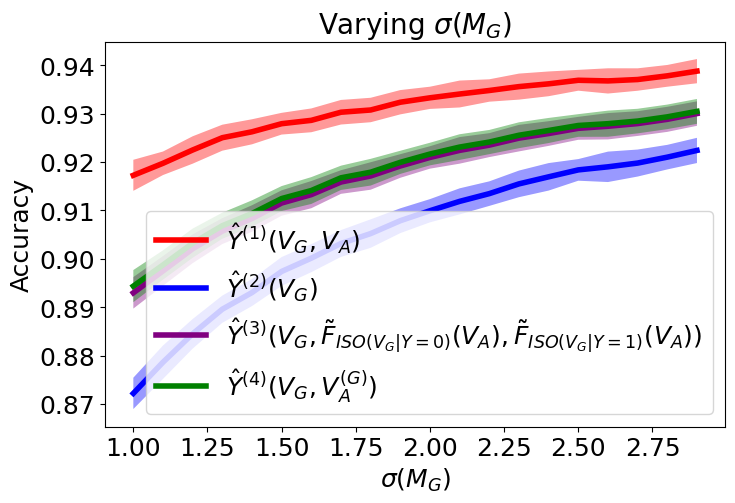

In [22]:
colors = ['red', 'blue', 'purple', 'green']
labels = [r'$\hat{Y}^{(1)}(V_G, V_A)$', 
              r'$\hat{Y}^{(2)}(V_G)$',
              r'$\hat{Y}^{(3)}(V_G, \tilde{F}_{ISO(V_G | Y=0)}(V_A), \tilde{F}_{ISO(V_G | Y=1)}(V_A))$', 
              r'$\hat{Y}^{(4)}(V_G, V_A^{(G)})$']
produce_plots(r'Varying $\sigma(M_G)$', r'$\sigma(M_G)$', xs, yhat_means, yhat_stds, labels, colors, legend=True)

In [23]:
y_hat_1, y_hat_2, y_hat_3, y_hat_4 = train_models(rotate_VA = rotate_VA)

xs = []
yhat_means = [[] for i in range(4)]
yhat_stds = [[] for i in range(4)]
for i in range(20):
    yhat1s = []
    yhat2s = []
    yhat3s = []
    yhat4s = []
    std = 1 + i/10
    xs.append(std)
    for j in range(100):
        X, y = generate_data(10000, std_MB = std, theta_deg = rotate_VA)
        yhat1s.append(y_hat_1.score(X[:,[0, 3, 4]], y))
        yhat2s.append(y_hat_2.score(X[:,[0]], y))
        yhat3s.append(y_hat_3.score(X, y))
        yhat4s.append(y_hat_4.score(X[:,[0, 1]], y))
    for yhat_index, yhats in enumerate([yhat1s, yhat2s, yhat3s, yhat4s]):
        yhat_means[yhat_index].append(np.mean(yhats))
        yhat_stds[yhat_index].append(np.std(yhats))
for i in range(4):
    yhat_means[i] = np.array(yhat_means[i])
    yhat_stds[i] = np.array(yhat_stds[i])

Y=1 50.029999999999994% of the time
Average Accuracy Conditioning: 0.7446425081201409
Accuracy No Conditioning: 0.8648887835772818
y1: 0.9218
y2: 0.8783
y3: 0.9025
y4: 0.9025


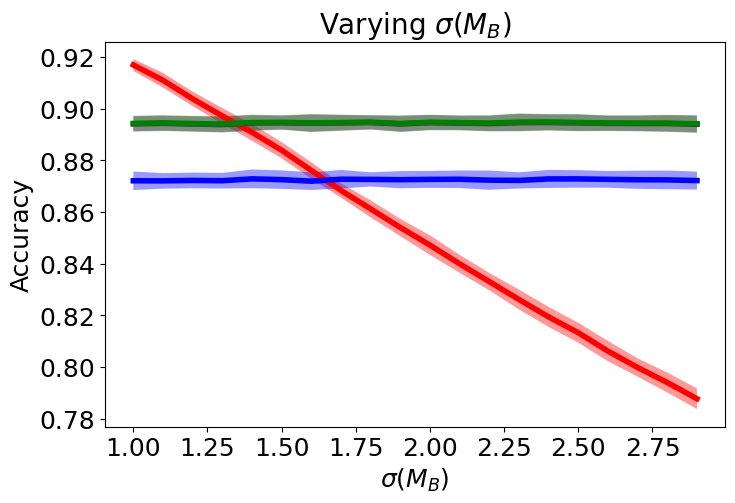

In [24]:
produce_plots(r'Varying $\sigma(M_B)$', r'$\sigma(M_B)$', xs, yhat_means, yhat_stds, labels, colors)